# <center>Predicting Year in Million Song Dataset using Spark</center>

In [1]:
from pyspark import SparkConf                                                                                                                 
from pyspark.context import SparkContext                                                                                                      
from pyspark.sql import SparkSession, SQLContext

sc = SparkContext('local')
spark = SparkSession(sc)

In [2]:
from pyspark import *
from pyspark.sql import *
from pyspark.sql.functions import *
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import *
from pyspark.ml.classification import *
from pyspark.ml.evaluation import *
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors
import pandas as pd

# Load the dataset
data = spark.read.csv('/Users/santoshdaptardar/Documents/ML with Spark/Data/MSD.txt', header=False, inferSchema=True)

# Using MinMax Scaler to scale the features from 0-1
v_assembler = VectorAssembler(inputCols=data.columns[1:], outputCol="features")
v_data = v_assembler.transform(data)
scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')
scale_model = scaler.fit(v_data)
scaled_data = scale_model.transform(v_data)
new_data = scaled_data.select(col('_c0').alias('label'), col('scaled_features').alias('features'))

# Get min and max year and normalize the labels by subtracting min year
min_year = new_data.agg({'label': 'min'}); max_year = new_data.agg({'label': 'max'})
min_year = min_year.take(1)[0][0]; max_year = max_year.take(1)[0][0]
normalize = udf(lambda x: x - min_year)
final_data = new_data.withColumn('new_label', normalize('label')).drop('label'). \
                    select(F.col('new_label').cast(FloatType()).alias('label'), 'features')

# Split data into train(70%), validation(10%) and test set(20%)
train, valid, test = final_data.randomSplit([0.7, 0.1, 0.2], seed = 15)
print('Training data points =', train.count(), '\nValidation data points =', valid.count(), \
      '\nTest data points =', test.count())

Training data points = 361094 
Validation data points = 51401 
Test data points = 102850


In [3]:
# Using linear regression model
from pyspark.ml.regression import LinearRegression
lrm = LinearRegression(featuresCol = 'features', labelCol='label', maxIter=50, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lr_Model = lrm.fit(train)
trainingSummary = lr_Model.summary

# Summarize the model over the training set and print out some metrics
print("RMSE on training data:", trainingSummary.rootMeanSquaredError)
print("R2 on training data:", trainingSummary.r2)

# Evaluating the model based on validation set.
lr_val_predictions = lr_Model.transform(valid)
lr_val_predictions.select("prediction","label","features").show(10)

from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="r2")

print("R Squared (R2) on validation data =", lr_evaluator.evaluate(lr_val_predictions))

val_result = lr_Model.evaluate(valid)
print("Root Mean Squared Error (RMSE) on validation set =", val_result.rootMeanSquaredError)

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("\nobjectiveHistory:")

# Collecting training error for each iteration using a dataframe
training_error_df = pd.DataFrame(columns=['iteration', 'training_error'])
i = 0

for objective in objectiveHistory:
    i += 1
    training_error_df = training_error_df.append({'iteration': i, 'training_error': 10 ** (objective)}, ignore_index=True)

print(training_error_df.shape)

RMSE on training data: 9.73110493081151
R2 on training data: 0.20844442735444624
+------------------+-----+--------------------+
|        prediction|label|            features|
+------------------+-----+--------------------+
| 71.25992013197201|  4.0|[0.42914797029747...|
|  73.0329588968724|  5.0|[0.40366040895273...|
| 70.63080174332009|  5.0|[0.61111563148754...|
| 63.40511271451693|  7.0|[0.34348004703995...|
|61.491258193561116|  7.0|[0.41340084229557...|
| 65.05011619129431|  7.0|[0.47933516369832...|
| 69.80251228885477|  7.0|[0.53848233361241...|
| 69.30783498341364|  7.0|[0.56090668492824...|
| 63.67824871230167|  8.0|[0.56175240123318...|
|62.961593641592316|  9.0|[0.58430195775104...|
+------------------+-----+--------------------+
only showing top 10 rows

R Squared (R2) on validation data = 0.20542184681861064
Root Mean Squared Error (RMSE) on validation set = 9.718869730751331

objectiveHistory:
(51, 2)


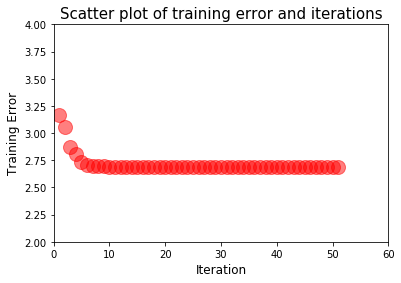

In [6]:
import matplotlib.pyplot as plt

axes = plt.gca()
axes.set_xlim([0,60])
axes.set_ylim([2,4])

plt.scatter(training_error_df['iteration'], training_error_df['training_error'], \
            s=14**2, c='red', alpha=0.5)
axes.set_title("Scatter plot of training error and iterations", fontsize=15)
axes.set_xlabel('Iteration', fontsize=12)
axes.set_ylabel('Training Error', fontsize=12)
plt.show()

In [7]:
test_result = lr_Model.evaluate(test)
print("Root Mean Squared Error (RMSE) on test data =", test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 9.744908828244753
